In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import plotly.express as px

In [ ]:

orig_df = df = pd.read_csv(r"athlete_events.csv")

In [ ]:
print(df['NOC'].nunique())
print(df['NOC'])

In [ ]:
df['Sport']

 e. ta reda på statistik för åldern: medelvärde, median, min, max, standardavvikelse,

In [ ]:
print(df['Age'].mean())
print(df['Age'].median())
print(df['Age'].min())
print(df['Age'].max())
print(df['Age'].std())

In [ ]:
df = df.fillna({'Age': 0, 'Height': 0, 'Weight': 0, 'ID': 0})
df = df.astype({'Age': 'uint8', 'Height': 'uint8', 'Weight': 'uint8', 'ID': 'uint32' , 'Year': 'int16'})
df.info()

In [ ]:
df['Sex'].value_counts().plot(kind='bar', color=['blue', 'red'])

In [ ]:

gender_year_season = df.groupby(['Season', 'Year', 'Sex']).size().unstack(fill_value=0)


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

gender_year_season.loc['Summer'].plot(ax=axes[0], marker='o')
axes[0].set_title('Summer OS')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Nbr of athletes')
axes[0].legend()
axes[0].grid(True)

gender_year_season.loc['Winter'].plot(ax=axes[1], marker='o')
axes[1].set_title('Winter OS')
axes[1].set_xlabel('Year')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
df.groupby('NOC')['Medal'].count().sort_values(ascending=False).iloc[:10].plot.bar()

# ITALIA

In [ ]:
italydf = orig_df[orig_df['NOC'] == 'ITA']
italydf

### Panagiotis: Cycling (you knew it)

The Olympic games, like most organized sports, has historically excluded women.\
For this reason we'll compare cycling participation of each event over the years, split by gender.\
\
As we can see, women have only been allowed to compete since 1980, and even then it was only one discipline.\
Participation increased slowly, and in 1996 when the more modern MTB and TT events were introduced women were ready at the start.\
Since 2012 the cycling events are homogenous - women and men participate in the same, albeit separated, disciplines.

In [35]:
cycling_df = orig_df[orig_df["Sport"] == "Cycling"].copy()

def base_event(event):
    event = event.replace("Cycling ", "")
    event = event.replace("Men's ", "")
    event = event.replace("Women's ", "")
    return event

cycling_df.loc[:, "Base Event"] = cycling_df["Event"].apply(base_event)

unique_base_events = cycling_df["Base Event"].unique()

men_event_amount = (cycling_df[cycling_df["Sex"] == "M"].groupby("Base Event")["Year"].nunique())
sorted_base_events = sorted(unique_base_events, key=lambda x: men_event_amount.get(x, 0), reverse=True)

cycling_df["Grouped Event"] = cycling_df.apply(lambda row: f"{"Men's" if row["Sex"] == "M" else "Women's"} {row["Base Event"]}", axis=1)

heatmap_data = cycling_df.groupby(["Grouped Event", "Year"])["ID"].count().reset_index()
heatmap_data["Base Event"] = heatmap_data["Grouped Event"].apply(lambda x: x.split(" ", 1)[1])

heatmap_data["Base Event Order"] = heatmap_data["Base Event"].apply(lambda x: sorted_base_events.index(x))
heatmap_data["Gender"] = heatmap_data["Grouped Event"].apply(lambda x: x.split(" ", 1)[0])
heatmap_data = heatmap_data.sort_values(by=["Base Event Order", "Gender"])

heatmap_data = heatmap_data.drop(columns=["Base Event", "Base Event Order", "Gender"])
heatmap_data = heatmap_data.iloc[::-1]

color_scale = [[0.0, "white"], [0.001, "lightgreen"], [1.0, "darkblue"]]

fig = px.density_heatmap(
    heatmap_data,
    x="Year",
    y="Grouped Event",
    z="ID",
    nbinsx=int((cycling_df["Year"].max()-cycling_df["Year"].min()+4)/4),
    color_continuous_scale=color_scale,
    title="Cycling through the Olympics",
    labels={"ID": "Number of Participants"},
    height=800,
    text_auto=True,
)

end_year = cycling_df["Year"].max()
tick_vals = list(range(1896, end_year + 1, 8))


fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Event",
    coloraxis_colorbar={"title": "Participants"},
    xaxis=dict(tickmode="array", tickvals=tick_vals)
    
)

fig.add_annotation(
    text="Amount of cycling event participants by year and event", xref="paper", yref="paper", x=0.5, y=1.05, showarrow=False, font=dict(size=14))

fig.show()


### Cycling medal distribution by country

Team duplicates are removed, counting only by unique event and year.\
Road cycling culture may be primarily associated with France and Italy, but UK is definitely on level with France, and US & Australia also provide a solid supply of ambitious cyclists.

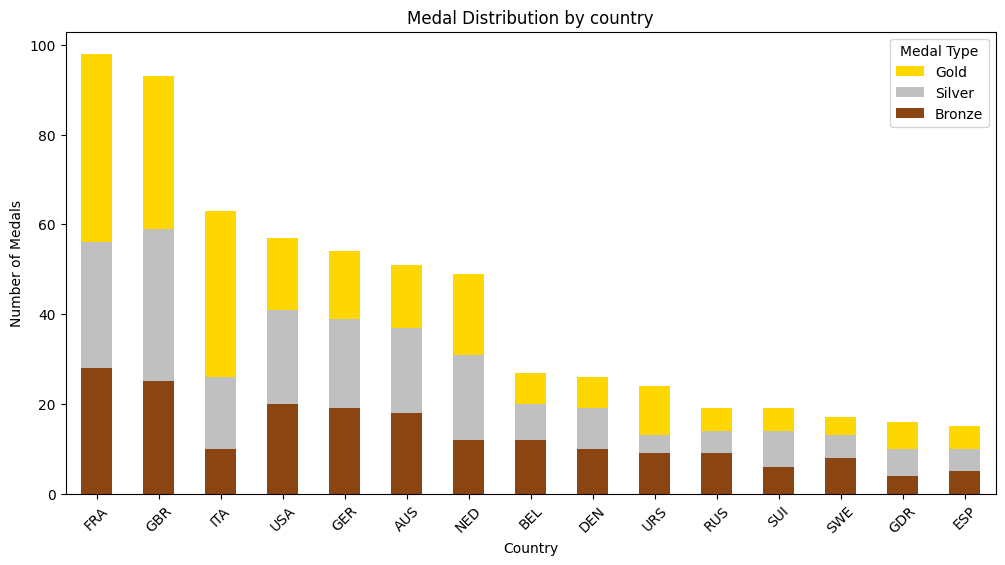

In [38]:
national_cycling_df = cycling_df[["NOC", "Year", "Event", "Medal"]].drop_duplicates()
medal_distribution = national_cycling_df.groupby("NOC")["Medal"].value_counts().unstack().fillna(0)
medal_distribution = medal_distribution.assign(Total=medal_distribution.sum(axis=1)).sort_values(by="Total", ascending=False).iloc[:15]


ax = medal_distribution[["Bronze", "Silver", "Gold"]].plot(
    kind="bar",
    stacked=True,
    title="Medal Distribution by country",
    figsize=(12, 6),
    xlabel="Country",
    ylabel="Number of Medals",
    color=["saddlebrown", "silver", "gold"]
)

ax.tick_params(axis='x', labelrotation=45)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Medal Type")

plt.show()

### Medal distribution by age

How does aging affect likelihood to score a medal in the Olympics?\
While entering their 30's (and even 40's) may not end the chances of an Olympic medal for athletes of endurance sports like cycling,\
the chances drop sharply after passing their mid-20's.

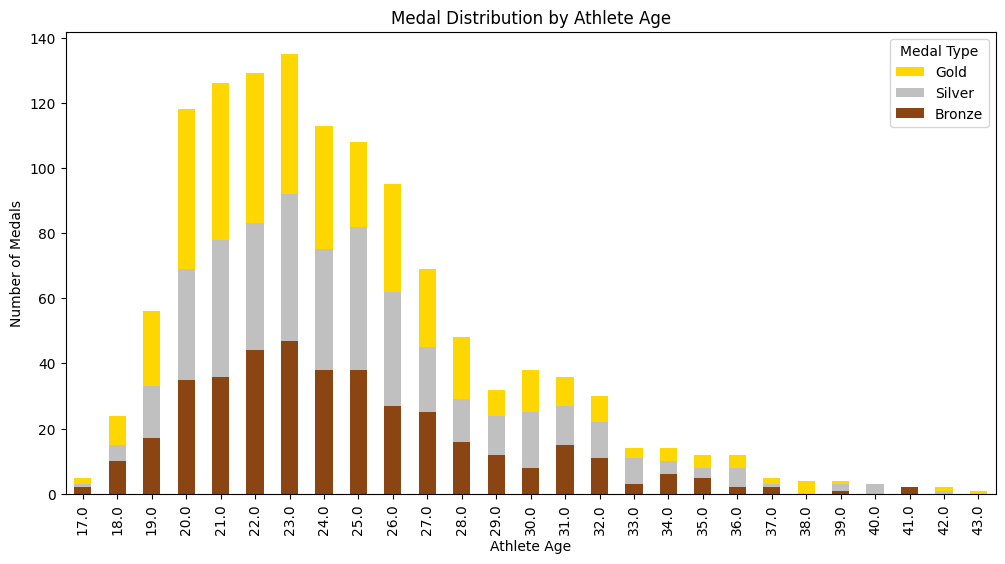

In [16]:
medal_distribution = cycling_df.groupby("Age")["Medal"].value_counts().unstack().fillna(0)

ax = medal_distribution[["Bronze", "Silver", "Gold"]].plot(
    kind="bar",
    stacked=True,
    title="Medal Distribution by Athlete Age",
    figsize=(12, 6),
    xlabel="Athlete Age",
    ylabel="Number of Medals",
    color=["saddlebrown", "silver", "gold"]
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Medal Type")

plt.show()

### Italy's cycling medals over the years

Italy had a significant impact on the Olympic cycling scene during the 20th century.
While claiming few medals early on they start to climb after the first world war,\
and following a bump during the second they enjoy prominent success during the 50's and 60's.

However, the "Years of lead" during the late 60's to late 80's almost wipes their medal proportion,\
and while they start recovering toward the 21st century cycling also broadens during this time.\

With other nations catching up to Italy in the traditional road & velodrome disciplines,\
the addition of the american BMX & MTB events also dilute Italy's medal proportion during the modern Olympics.


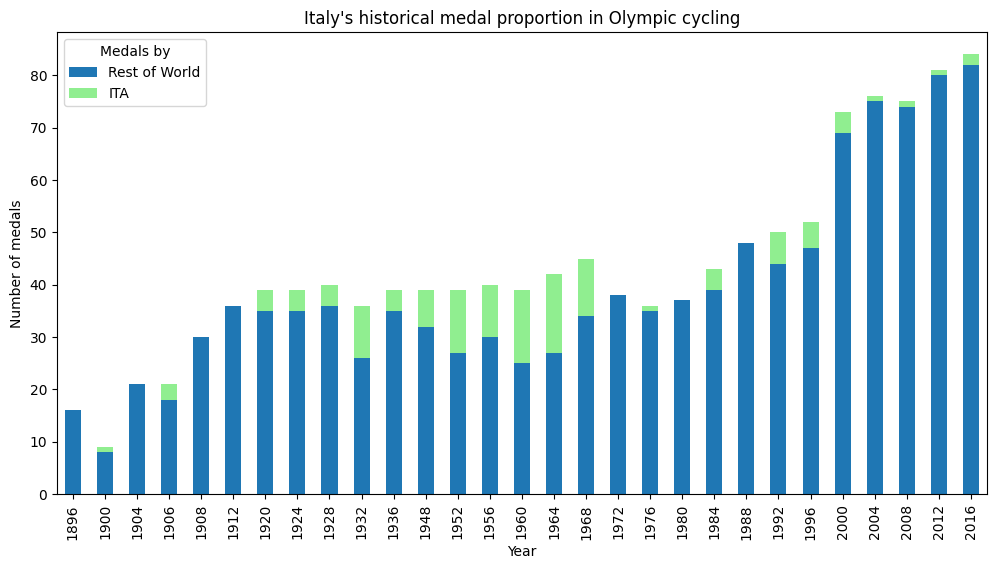

In [72]:
(cycling_df.groupby(["Year", "NOC"])["Medal"]
    .count()
    .unstack(fill_value=0)
    .assign(**{"Rest of World": lambda df: df.drop(columns=["ITA"]).sum(axis=1)})[["Rest of World", "ITA"]]
    .plot.bar(
        stacked=True,
        title="Italy's historical medal proportion in Olympic cycling",
        figsize=(12, 6),
        xlabel="Year",
        ylabel="Number of medals",
        color=["tab:blue", "lightgreen"]
    )
)
plt.legend(title="Medals by")
plt.show()
